# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Find-distance-between-two-points" data-toc-modified-id="Find-distance-between-two-points-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Find distance between two points</a></div><div class="lev1 toc-item"><a href="#Find-distance-between-two-points-constrained-by-another-vector" data-toc-modified-id="Find-distance-between-two-points-constrained-by-another-vector-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Find distance between two points constrained by another vector</a></div><div class="lev1 toc-item"><a href="#Find-distance-between-large-number-of-points-in-for-loop" data-toc-modified-id="Find-distance-between-large-number-of-points-in-for-loop-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find distance between large number of points in for loop</a></div><div class="lev2 toc-item"><a href="#Efficency-by-spatial-indexing" data-toc-modified-id="Efficency-by-spatial-indexing-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Efficency by spatial indexing</a></div>

# Find distance between two points

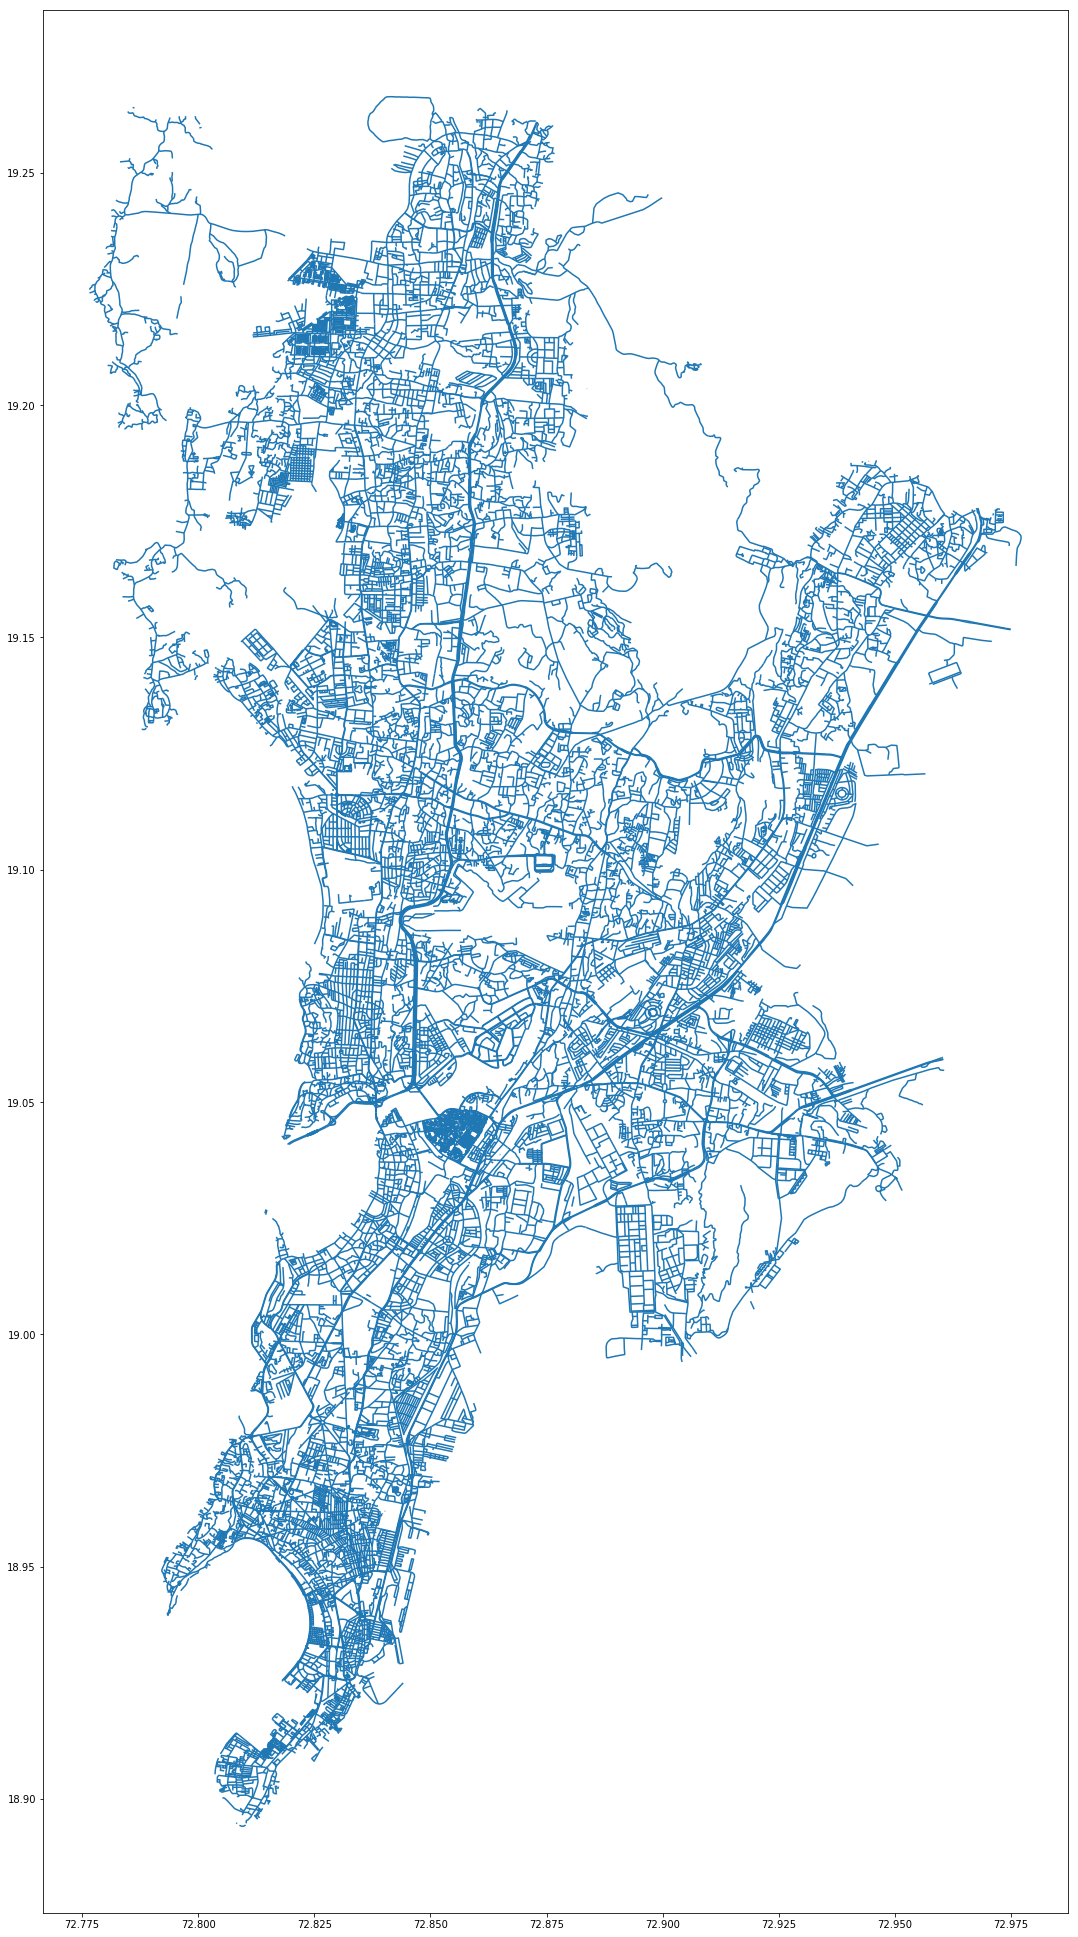

In [12]:
%matplotlib inline
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 35]

qq=gp.read_file('../data/vector/Mumbai_roads.geojson')
qq.plot()

In [13]:
qq['length']=qq.apply(lambda row: row['geometry'].length*100, axis=1)

# Find distance between two points constrained by another vector

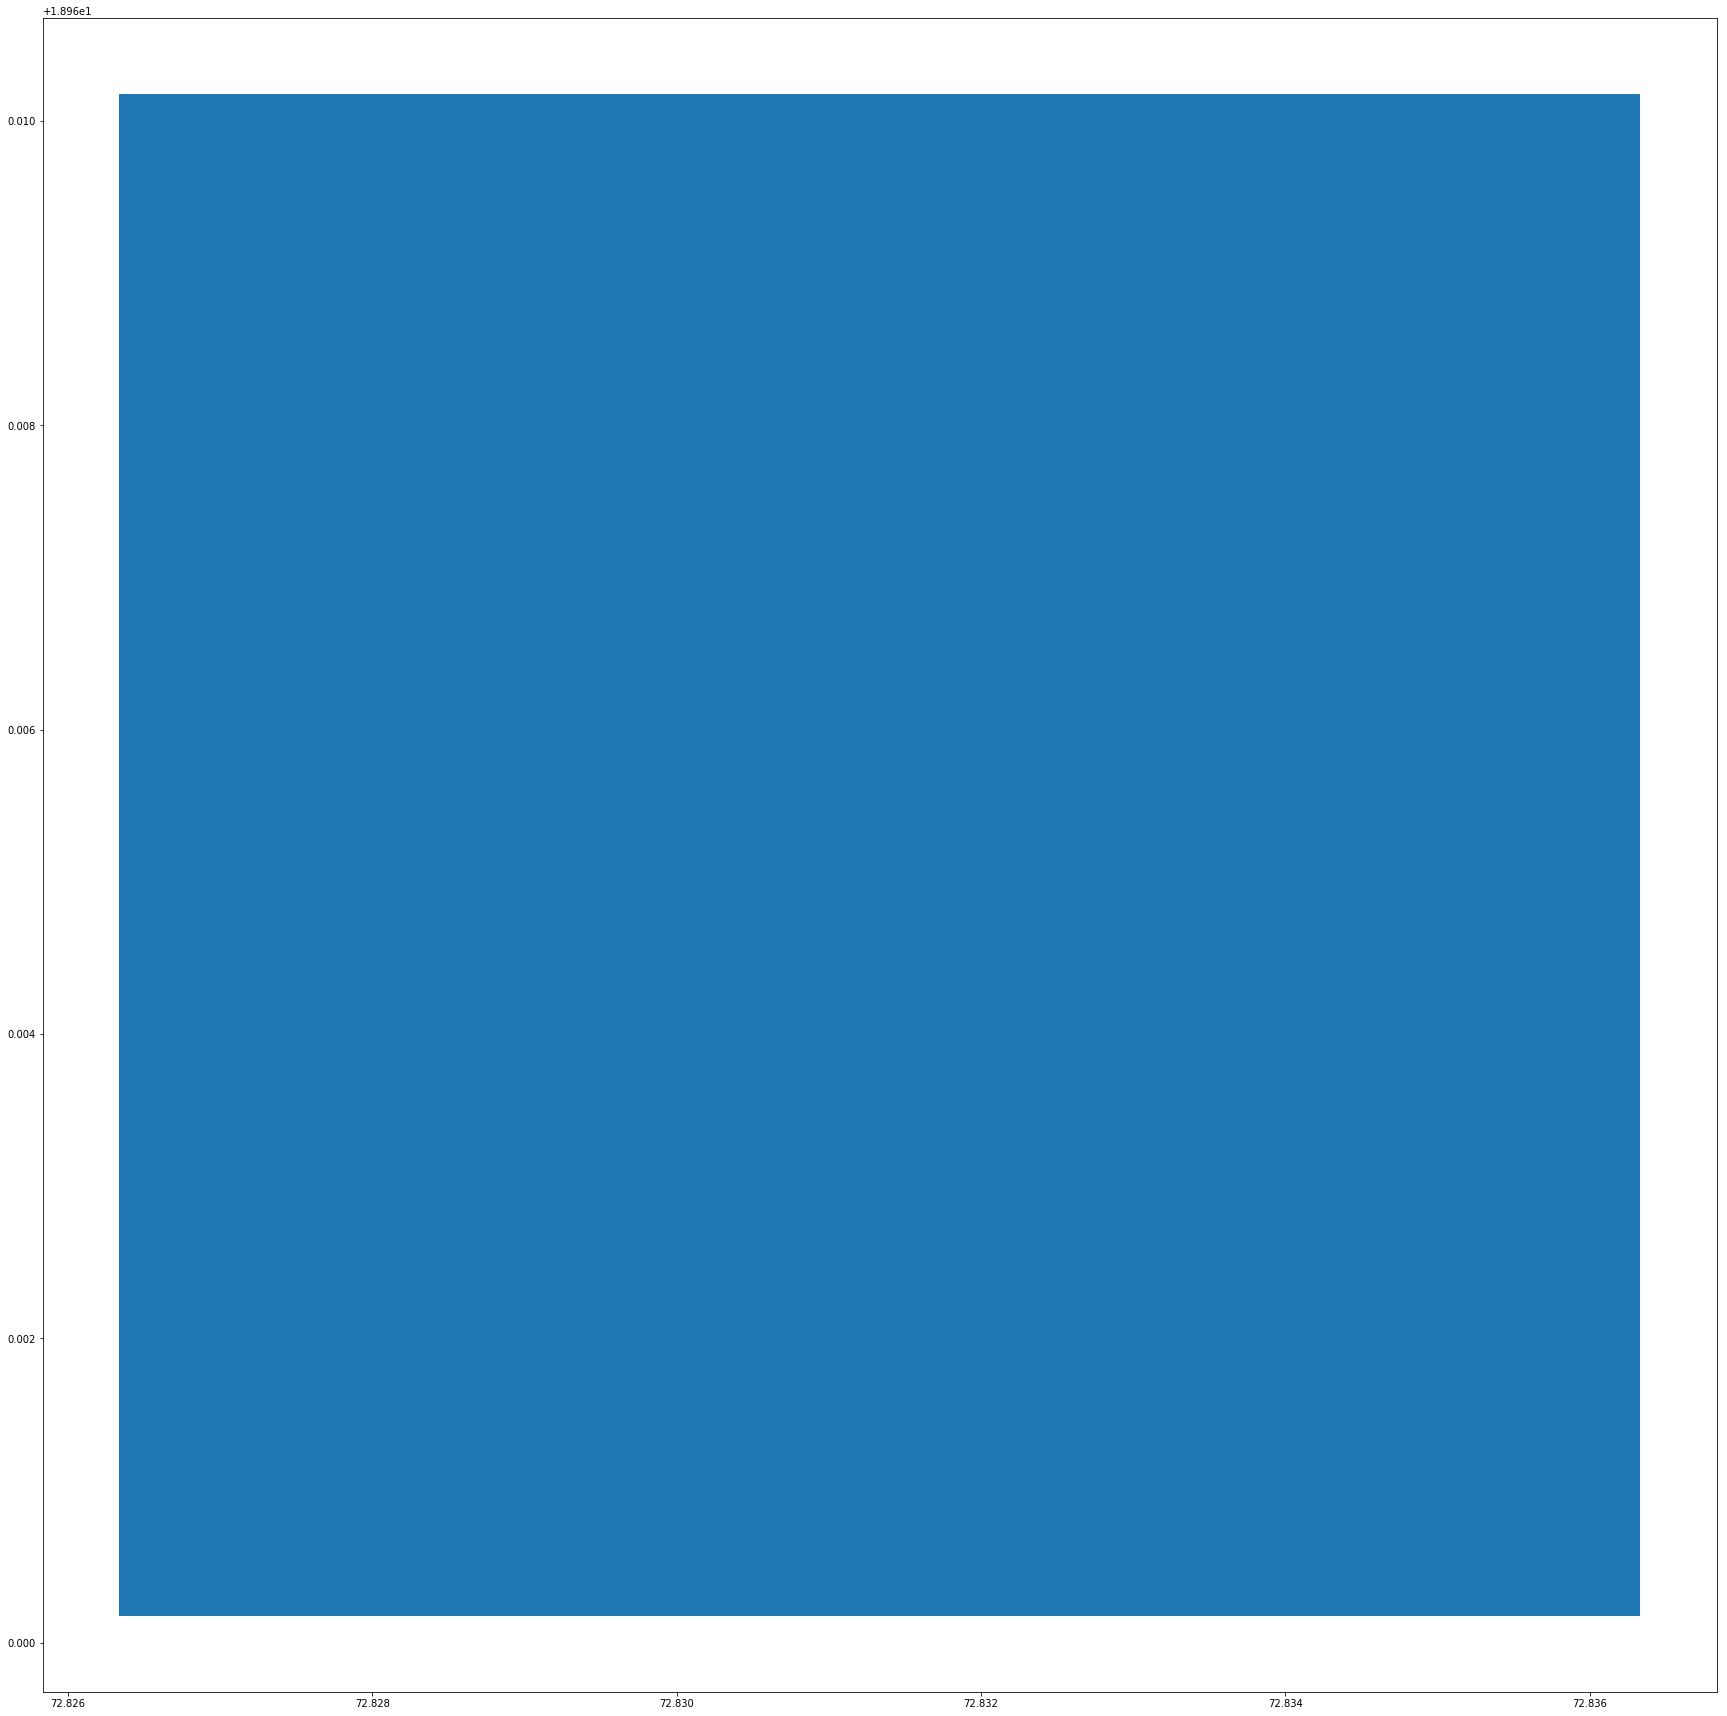

In [17]:
#fig=plt.figure(figsize=(48, 46), dpi= 80, facecolor='r', edgecolor='k')
poly=gp.read_file('../data/vector/Mumbai_grid_1km.geojson')
poly1=poly[poly['VIL']==220]
poly1.plot()

In [18]:
%%time
data = []
for index, orig in poly1.iterrows():
    for index2, ref in qq.iterrows():      
        if ref['geometry'].intersects(orig['geometry']): 
            owdspd=orig['VIL']
            data.append({'geometry':ref['geometry'].intersection(orig['geometry']),'wdspd':owdspd})

CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2 s


In [21]:
data1=pd.DataFrame(data)
data2 = gp.GeoDataFrame(data1, geometry='geometry')
#data2.to_file('../data/vector/test.geojson', driver="GeoJSON")
#data2.plot()

#  Find distance between large number of points in for loop

In [22]:
grids=[206,207,208,243,244,245,246,247,248]
poly2=poly[poly['VIL'].isin(grids)]
#poly2

In [23]:
%%time
data = []
for index, orig in poly2.iterrows():
    for index2, ref in qq.iterrows():      
        if ref['geometry'].intersects(orig['geometry']): 
            owdspd=orig['VIL']
            data.append({'geometry':ref['geometry'].intersection(orig['geometry']),'wdspd':owdspd})

CPU times: user 48.4 s, sys: 28.3 ms, total: 48.4 s
Wall time: 48.4 s


## Efficency by spatial indexing

In [24]:
import geopandas as gp
qq=gp.read_file('../data/vector/Mumbai_grid_1km.geojson')

qq.to_file('../data/vector/Mumbai_grid_1km.shp', driver='ESRI Shapefile')

rr=gp.read_file('../data/vector/Mumbai_roads.geojson')

rr.to_file('../data/vector/Mumbai_roads.shp', driver='ESRI Shapefile')

In [28]:
%%time
import fiona
from shapely.geometry import shape, mapping
import rtree


def intersect(boundarySHP,roadSHP,outSHP):
    with fiona.open(boundarySHP, 'r') as layer1:
        with fiona.open(roadSHP, 'r') as layer2:
        # We copy schema and add the  new property for the new resulting shp
            schema = layer2.schema.copy()
            schema['properties']['gno'] = 'int:10'
            schema['properties']['length'] = 'float:15.2'
        # We open a first empty shp to write new content from both others shp
            with fiona.open(outSHP, 'w', 'ESRI Shapefile', schema) as layer3:
                index = rtree.index.Index()
                for feat1 in layer1:
                    fid = int(feat1['id'])
                    geom1 = shape(feat1['geometry'])
                    index.insert(fid, geom1.bounds)
                for feat2 in layer2:
                    geom2 = shape(feat2['geometry'])
                    for fid in list(index.intersection(geom2.bounds)):
                        if fid != int(feat2['id']):
                            feat1 = layer1[fid]
                            geom1 = shape(feat1['geometry'])
                            if geom1.intersects(geom2):
                                # We take attributes from ctSHP
                                props = feat2['properties']
                                # Then append the uid attribute we want from the other shp
                                geom3=geom1.intersection(geom2)
                                if geom3.geom_type=='GeometryCollection':
                                    print("empty geometry")
                                elif geom3.geom_type=='Point':
                                    print(props)
                                else:
                                    props['gno'] = feat1['properties']['VIL']
                                    props['length']=geom3.length*100
                                    layer3.write({
                                    'properties': props,
                                    'geometry': mapping(geom1.intersection(geom2))
                                    })
                                    

outSHP='../data/vector/results.shp'
boundarySHP='../data/vector/Mumbai_grid_1km.shp'
roadSHP='../data/vector/Mumbai_roads.shp'

intersect(boundarySHP,roadSHP,outSHP)

CPU times: user 21.7 s, sys: 419 ms, total: 22.1 s
Wall time: 22.1 s


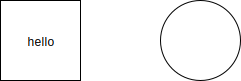

In [2]:
from IPython.display import SVG, display
def show_svg():
    display(SVG('untitled.svg'))
show_svg()